<a href="https://colab.research.google.com/github/Sylvia232/COMPSCI-675D-Final-Project/blob/main/RealDataset_Tarnet_VaryingBeta%26Dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/archive.zip"  # adjust path
data_dir = "Data"

In [4]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print("Data extracted from Drive!")


Data extracted from Drive!


In [5]:
import os

data_dir = "Data/Data"
for split in ["train", "test"]:
    split_path = os.path.join(data_dir, split)
    print(f"\nContents of {split_path}:")
    if os.path.exists(split_path):
        print(os.listdir(split_path))
    else:
        print("Folder does not exist!")



Contents of Data/Data/train:
['NORMAL', 'COVID19', 'PNEUMONIA']

Contents of Data/Data/test:
['NORMAL', 'COVID19', 'PNEUMONIA']


In [6]:
# Import libraries
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd

# Define MedicalImageDataset
class MedicalImageDataset(Dataset):
    def __init__(self, data_dir, split='train', image_size=64,
                 confounder_dim=8, beta_strength=1.0):
        self.data_dir = Path(data_dir) / split
        self.image_size = image_size
        self.confounder_dim = confounder_dim
        self.beta_strength = beta_strength

        self.image_paths = []
        self.categories = []

        for category in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            category_path = self.data_dir / category
            if category_path.exists():
                for img_path in sorted(category_path.glob('*.jpg')):
                    self.image_paths.append(img_path)
                    self.categories.append(category)

        print(f"\nLoaded {len(self.image_paths)} images from {split} split")
        category_counts = pd.Series(self.categories).value_counts()
        print(f"Categories: {category_counts.to_dict()}")

        self._generate_confounders_and_treatment()

    def _load_image(self, img_path):
        img = Image.open(img_path).convert('L')
        img = img.resize((self.image_size, self.image_size))
        img = np.array(img, dtype=np.float32) / 255.0
        img = (img - 0.5) / 0.5
        return torch.FloatTensor(img).unsqueeze(0)

    def _generate_confounders_and_treatment(self):
        n = len(self.image_paths)
        Z2 = np.random.randn(n, self.confounder_dim)
        self.U = Z2 + np.random.randn(n, self.confounder_dim) * 0.1

        severity_map = {'NORMAL': 0.0, 'PNEUMONIA': 0.5, 'COVID19': 1.0}
        severity = np.array([severity_map[cat] for cat in self.categories])

        alpha = 2.0
        beta = np.random.randn(self.confounder_dim)
        beta = beta / np.linalg.norm(beta) * self.beta_strength

        logits = alpha * severity + self.U @ beta
        propensity = 1 / (1 + np.exp(-logits))
        self.T = (np.random.rand(n) < propensity).astype(np.int64)

        base_outcome = severity * 5.0 + self.U[:, 0] * 1.0 + np.random.randn(n) * 0.5
        treatment_effect = -(2.0 + severity * 3.0 + self.U[:, 1] * 0.5)

        self.Y0 = base_outcome + np.random.randn(n) * 0.3
        self.Y1 = base_outcome + treatment_effect + np.random.randn(n) * 0.3
        self.Y = self.T * self.Y1 + (1 - self.T) * self.Y0
        self.true_ITE = self.Y1 - self.Y0

        print(f"Treatment rate: {self.T.mean():.3f}")
        print(f"True ATE: {self.true_ITE.mean():.3f}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self._load_image(self.image_paths[idx])
        return {
            'image': img,
            'treatment': torch.LongTensor([self.T[idx]])[0],
            'outcome': torch.FloatTensor([self.Y[idx]])[0],
            'y0': torch.FloatTensor([self.Y0[idx]])[0],
            'y1': torch.FloatTensor([self.Y1[idx]])[0],
            'ite': torch.FloatTensor([self.true_ITE[idx]])[0],
            'category': self.categories[idx]
        }

#
image_size = 64
confounder_dim = 8
beta_strength = 1.0
batch_size = 32

train_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='train',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

test_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='test',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders ready! Batch size: {batch_size}")



Loaded 5144 images from train split
Categories: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Treatment rate: 0.668
True ATE: -3.265

Loaded 1288 images from test split
Categories: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Treatment rate: 0.672
True ATE: -3.266

DataLoaders ready! Batch size: 32


In [7]:
class CNNFeatureExtractor(nn.Module):
    """CNN with 3-4 conv layers for medical image feature extraction"""
    def __init__(self, in_channels=1, output_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        rep = self.features(x)
        rep = rep.view(rep.size(0), -1)
        return self.fc(rep)

class TARNet(nn.Module):
    """Treatment-Agnostic Representation Network with separate MLP heads"""
    def __init__(self, cnn_feat, rep_dim=256, hidden_dim=200):
        super().__init__()
        self.cnn_feat = cnn_feat

        # MLP head for control outcome Y0
        self.head_0 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )

        # MLP head for treatment outcome Y1
        self.head_1 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, t=None):
        rep = self.cnn_feat(x)
        y0 = self.head_0(rep).squeeze(-1)
        y1 = self.head_1(rep).squeeze(-1)

        if t is None:
            return y0, y1, rep
        else:
            y = torch.where(t == 1, y1, y0)
            return y, y0, y1, rep

In [8]:
# Create the CNN feature extractor
cnn_feat = CNNFeatureExtractor(in_channels=1, output_dim=256)

# Create TARNet using that CNN
model = TARNet(cnn_feat, rep_dim=256, hidden_dim=200)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [10]:
def train_model(model, train_loader, num_epochs=20, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    train_losses = []
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch in train_loader:
            images = batch['image'].to(device)
            treatments = batch['treatment'].to(device).float()
            outcomes = batch['outcome'].to(device)

            optimizer.zero_grad()
            y_pred, _, _, _ = model(images, treatments)
            loss = criterion(y_pred, outcomes)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return train_losses

In [11]:
print("\nTraining TARNet:")
train_losses = train_model(model, train_loader, num_epochs=20, lr=0.001)

torch.save(model.state_dict(), 'tarnet_medical_images.pth')
print("\nModel saved to tarnet_medical_images.pth")

plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()


Training TARNet:


KeyboardInterrupt: 

In [13]:
def evaluate_model(model, data_loader):
    """Evaluate TARNet and compute PEHE and ATE errors"""
    model.eval()

    all_y0_pred = []
    all_y1_pred = []
    all_y0_true = []
    all_y1_true = []
    all_ite_true = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            y0_pred, y1_pred, _ = model(images, t=None)

            all_y0_pred.append(y0_pred.cpu().numpy())
            all_y1_pred.append(y1_pred.cpu().numpy())
            all_y0_true.append(batch['y0'].numpy())
            all_y1_true.append(batch['y1'].numpy())
            all_ite_true.append(batch['ite'].numpy())

    y0_pred = np.concatenate(all_y0_pred)
    y1_pred = np.concatenate(all_y1_pred)
    y0_true = np.concatenate(all_y0_true)
    y1_true = np.concatenate(all_y1_true)
    ite_true = np.concatenate(all_ite_true)

    ite_pred = y1_pred - y0_pred

    # Calculate metrics
    pehe = np.sqrt(np.mean((ite_pred - ite_true) ** 2))
    ate_true = ite_true.mean()
    ate_pred = ite_pred.mean()
    ate_error = np.abs(ate_true - ate_pred)

    print(f"\n{'='*50}")
    print("EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"√PEHE (lower is better):    {pehe:.4f}")
    print(f"True ATE:                   {ate_true:.4f}")
    print(f"Predicted ATE:              {ate_pred:.4f}")
    print(f"ATE Error:                  {ate_error:.4f}")
    print(f"{'='*50}\n")

    return ite_pred, ite_true, y0_pred, y1_pred, y0_true, y1_true

In [ ]:

# Evaluate on test set
ite_pred, ite_true, y0_pred, y1_pred, y0_true, y1_true = evaluate_model(model, test_loader)

different values of beta and hidden dimension

In [14]:
confounder_dims = [2, 4, 8, 16]
beta_strengths = [0.5, 1.0, 2.0, 4.0]
pehe_results = np.zeros((len(confounder_dims), len(beta_strengths)))


In [18]:
conf_dim = 10            # choose one
pehe_beta = []

for beta in beta_strengths:


    # Dataset
    train_dataset = MedicalImageDataset(
        data_dir=data_dir,
        split='train',
        image_size=image_size,
        confounder_dim=conf_dim,
        beta_strength=beta
    )
    test_dataset = MedicalImageDataset(
        data_dir=data_dir,
        split='test',
        image_size=image_size,
        confounder_dim=conf_dim,
        beta_strength=beta
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model
    cnn_feat = CNNFeatureExtractor(in_channels=1, output_dim=256)
    model = TARNet(cnn_feat, rep_dim=256, hidden_dim= 200).to(device)

    train_model(model, train_loader, num_epochs=10, lr=0.001)

    ite_pred, ite_true, *_ = evaluate_model(model, test_loader)
    pehe = np.sqrt(np.mean((ite_pred - ite_true) ** 2))

    pehe_beta.append(pehe)
    print(f"PEHE at beta={beta}: {pehe:.4f}")



Loaded 5144 images from train split
Categories: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Treatment rate: 0.671
True ATE: -3.263

Loaded 1288 images from test split
Categories: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Treatment rate: 0.675
True ATE: -3.243
Epoch 1/10, Loss: 2.3479
Epoch 2/10, Loss: 2.2183
Epoch 3/10, Loss: 2.1541
Epoch 4/10, Loss: 1.9583
Epoch 5/10, Loss: 1.9177
Epoch 6/10, Loss: 1.8910
Epoch 7/10, Loss: 1.8741
Epoch 8/10, Loss: 1.8420
Epoch 9/10, Loss: 1.8345
Epoch 10/10, Loss: 1.8166

EVALUATION RESULTS
√PEHE (lower is better):    0.8908
True ATE:                   -3.2429
Predicted ATE:              -3.1511
ATE Error:                  0.0919

PEHE at beta=0.5: 0.8908

Loaded 5144 images from train split
Categories: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Treatment rate: 0.666
True ATE: -3.259

Loaded 1288 images from test split
Categories: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Treatment rate: 0.667
True ATE: -3.275
Epoch 1

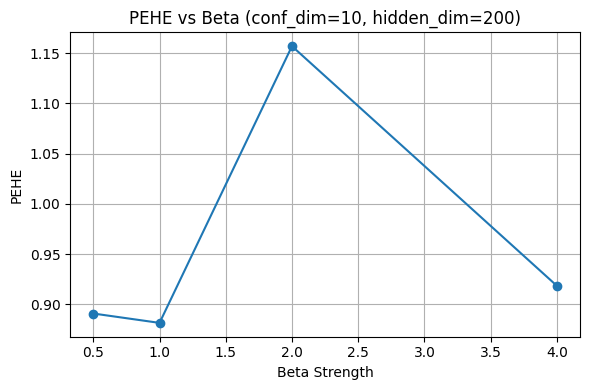

In [19]:
plt.figure(figsize=(6,4))
plt.plot(beta_strengths, pehe_beta, marker='o')
plt.title(f"PEHE vs Beta (conf_dim={conf_dim}, hidden_dim={hidden_dim})")
plt.xlabel("Beta Strength")
plt.ylabel("PEHE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
beta = 2               # choose one
pehe_confounder = []

for conf_dim in confounder_dims:

    train_dataset = MedicalImageDataset(
        data_dir=data_dir,
        split='train',
        image_size=image_size,
        confounder_dim=conf_dim,
        beta_strength=beta
    )
    test_dataset = MedicalImageDataset(
        data_dir=data_dir,
        split='test',
        image_size=image_size,
        confounder_dim=conf_dim,
        beta_strength=beta
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model with variable hidden_dim
    cnn_feat = CNNFeatureExtractor(in_channels=1, output_dim=256)
    model = TARNet(cnn_feat, rep_dim=256, hidden_dim= 200).to(device)

    train_model(model, train_loader, num_epochs=10, lr=0.001)

    ite_pred, ite_true, *_ = evaluate_model(model, test_loader)
    pehe = np.sqrt(np.mean((ite_pred - ite_true) ** 2))

    pehe_hidden.append(pehe)
    print(f"PEHE at confounder dim={conf_dim}: {pehe:.4f}")


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(confounder_dims, pehe_confounder, marker='o')
plt.title(f"PEHE vs Hidden Dim (beta={beta}, conf_dim={conf_dim})")
plt.xlabel("Hidden Dimension")
plt.ylabel("PEHE")
plt.grid(True)
plt.tight_layout()
plt.show()
